In [ ]:
import autograd
from autograd import grad,jacobian,hessian
from autograd.scipy import stats as agss
import autograd.numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import scipy.stats as ss
import os
from glob import glob
from multiinstance.data.syntheticData import buildDataset
from multiinstance.utils import *

In [ ]:
# os.sched_setaffinity(0, range(20,40))

In [ ]:
# export
def logLikelihood(xi,mu,sigma,normalize):
    LL = (-len(xi)/2 * np.log(2*np.pi*(sigma + 1e-8)**2) - (1/(2*(sigma + 1e-8)**2)) * np.sum((xi - mu)**2))
    if normalize:
        LL = LL * (1/len(xi))
    return LL

def getChildren(idx,N):
    if idx > N - 1:
        return np.array([idx])
    left = 2 * idx + 1
    right = left + 1
    
    return np.concatenate([getChildren(left,N),getChildren(right,N)])

def treeNegativeLogLikelihood(x,leafN,normalize=True,rlambda=.5):
    def LL(leafMeans,bagSigma):
        NBags = len(bagSigma)
        NInternal_Nodes = np.floor(NBags/2)
        NLeaves = len(leafMeans)
        ll = 0
        Nrows = int(np.ceil(np.log2(NLeaves))) + 1
        for row in range(Nrows):
            for col in range(2**row):
                idx = col
                if row > 0:
                    idx += 2**(row) - 1                
                leafIndices = (getChildren(idx, NInternal_Nodes) - NInternal_Nodes).astype(int)
                ln = leafN[leafIndices]
                mu = np.dot(leafMeans[leafIndices],ln)/np.sum(ln)
                sigma = bagSigma[idx]
                ll = ll + (rlambda**row) * logLikelihood(x[idx],mu,sigma,normalize)
        return -1 * ll
    return LL

In [4]:
def prepDS(dsi,numbootstraps=100):
    dsi = addTransformScores(dsi)
    dsi = addGlobalEsts(dsi)
    dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,numbootstraps=numbootstraps)

    dsi.numLeaves = dsi.alphaHats.shape[0]
    dsi.numNodes = dsi.numLeaves + (dsi.numLeaves - 1)
    dsi.numInternal = dsi.numNodes - dsi.numLeaves

    dsi.mu = np.zeros(dsi.alphaHats.shape[0])
    dsi.sigma = np.ones(dsi.numNodes)
    dsi.leafN = np.ones_like(dsi.mu) * dsi.alphaHats.shape[1]
    dsi.treeAlphaHats = [[] for _ in range(dsi.numNodes)]

    for nodeNum in range(dsi.numInternal):
        children = getChildren(nodeNum, dsi.numInternal)
        leafNums = children - dsi.numInternal
        _,unlabeled = list(zip(*[getTransformScores(dsi,n) for n in leafNums]))
        pos,_ = list(zip(*[getTransformScores(dsi,n) for n in range(dsi.N)]))
        pos = np.concatenate(pos).reshape((-1,1))
        unlabeled = np.concatenate(unlabeled).reshape((-1,1))
        NEstimates = int(np.sum([dsi.leafN[l] for l in leafNums]))
        dsi.treeAlphaHats[nodeNum],_ = getEsts(pos, unlabeled, NEstimates)
        _, dsi.sigma[nodeNum] = ss.norm.fit(dsi.treeAlphaHats[nodeNum])

    for leafNum in range(dsi.numLeaves):
        nodeNum = leafNum + dsi.numInternal
        dsi.treeAlphaHats[nodeNum] = dsi.alphaHats[leafNum]
        dsi.mu[leafNum],dsi.sigma[nodeNum] = ss.norm.fit(dsi.treeAlphaHats[nodeNum])
    return dsi

def runAlgorithm(dsi,normalize=True,NIter=1000,rlambda=.5, lr=.01,newton=True):

    maes = [np.mean(np.abs(dsi.mu - dsi.trueAlphas.flatten()))]

    gradNLL_mu = grad(treeNegativeLogLikelihood(dsi.treeAlphaHats,
                                                dsi.leafN,
                                                normalize=normalize,
                                                rlambda=rlambda),0)
    hessianNLL_mu = hessian(treeNegativeLogLikelihood(dsi.treeAlphaHats,
                                                dsi.leafN,
                                                normalize=normalize,
                                                rlambda=rlambda),0)
    gradNLL_sigma = grad(treeNegativeLogLikelihood(dsi.treeAlphaHats,
                                                   dsi.leafN,
                                                   normalize=normalize,
                                                   rlambda=rlambda),1)
    
    hessianNLL_sigma = hessian(treeNegativeLogLikelihood(dsi.treeAlphaHats,
                                                   dsi.leafN,
                                                   normalize=normalize,
                                                   rlambda=rlambda),1)
    mus = [dsi.mu]
    negLogLikelihood = []
    nllfunc = treeNegativeLogLikelihood(dsi.treeAlphaHats, dsi.leafN)
    sigmas = [dsi.sigma]
    for i in tqdm(range(NIter),total=NIter):
        if not i % 1500:
            lr = lr * .5
        if newton:
            deltaMu =  np.linalg.inv(hessianNLL_mu(dsi.mu,
                                                   dsi.sigma)) @ gradNLL_mu(dsi.mu,
                                                                            dsi.sigma)
            deltaSigma = np.linalg.inv(hessianNLL_sigma(dsi.mu,
                                                        dsi.sigma)) @ gradNLL_sigma(dsi.mu,
                                                                                    dsi.sigma)
        else:
            deltaMu = gradNLL_mu(dsi.mu, dsi.sigma)
            deltaSigma = gradNLL_sigma(dsi.mu,dsi.sigma)
        mus.append(dsi.mu)
        sigmas.append(dsi.sigma)
        dsi.mu = dsi.mu - lr * deltaMu
        dsi.mu[dsi.mu <= 0] = .01
        negLogLikelihood.append(nllfunc(dsi.mu, dsi.sigma))
        dsi.sigma = dsi.sigma - lr * deltaSigma
        maes.append(np.mean(np.abs(dsi.mu - dsi.trueAlphas.flatten())))
    return dsi,mus,sigmas,maes,negLogLikelihood

def plotMAE(maes,dsi):
    fig,ax = plt.subplots()
    ax.plot(maes,label="likelihood method")
    ax.hlines(np.mean(np.abs(dsi.globalAlphaHats.mean() - dsi.trueAlphas.flatten())),
               0,len(maes),
               color="black",label="global")
    ax.legend()
    ax.set_ylabel("MAE")
    return fig

def plotDistrs(ds,mus_,sigmas_):
    Nrows = int(np.ceil(np.log2(ds.N))) + 1
    fig,ax= plt.subplots(nrows=Nrows,ncols=ds.N,figsize=(5 * ds.N,5 * ds.N))
    for row in range(Nrows):
        for col in range(2**row):
            idx = col
            if row > 0:
                idx += 2**(row) - 1
            ax[row,col].hist(ds.treeAlphaHats[idx],density=True)
            children = getChildren(0,1)
            leafIndices = getChildren(idx, ds.N - 1).astype(int) - (ds.N-1)
            ln = ds.numU[leafIndices]
            # Final
            mu = np.dot(ds.mu[leafIndices],ln)/np.sum(ln)
            sigma = ds.sigma[idx]
            pdf = ss.norm.pdf(np.arange(0,1,.01),
                              loc=mu,scale=sigma)
            ax[row,col].plot(np.arange(0,1,.01),pdf,color="green",alpha=.5,label="final")
            ax[row,col].vlines(mu,0,1,color="green",label="alpha hat")
            # Original
            mu = np.dot(mus_[0][leafIndices],ln)/np.sum(ln)
            sigma = sigmas_[0][idx]
            pdf = ss.norm.pdf(np.arange(0,1,.01),
                              loc=mu,scale=sigma)
            ax[row,col].plot(np.arange(0,1,.01),pdf,color="red",alpha=.5,label="og")
            truth = np.dot(ds.trueAlphas[leafIndices].flatten(), ln)/np.sum(ln)
            ax[row,col].vlines(truth,0,1,color="black",label="alpha")
            if row == Nrows - 1:
                ax[row,col].vlines(ds.trueAlphas[leafIndices[0]],0,1,color="black",label="alpha")
            ax[row,col].legend()
    return fig

In [ ]:
dsi = buildDataset(1,nP=10,nU=20,posMean=1,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.10]))
ds2 = buildDataset(1, nP=10,nU=20,posMean=1,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.90]))
dsi.merge(ds2)

dsi = prepDS(dsi,numbootstraps=1000)
dsi, mus,sigmas,maes,logLikelihood = runAlgorithm(dsi,
                                                  NIter=1000,
                                                  rlambda=.1)
maefig1 = plotMAE(maes,dsi)
fig1 = plotDistrs(dsi,mus,sigmas)

In [ ]:
dsi = buildDataset(1,nP=10,nU=30,posMean=1,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.10]))
ds2 = buildDataset(1, nP=10,nU=30,posMean=1,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.90]))
dsi.merge(ds2)

dsi = prepDS(dsi)
dsi, mus,sigmas,maes,logLikelihood = runAlgorithm(dsi,
                                                  NIter=5000,
                                                  rlambda=1)
maefig2 = plotMAE(maes,dsi)
fig2 = plotDistrs(dsi,mus,sigmas)

In [ ]:

dsi = buildDataset(4,nP=5,nU=20,
                   posMean=1,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.uniform(low=.1,high=.9))


dsi = prepDS(dsi,numbootstraps=1000)
dsi, mus,sigmas,maes,logLikelihood = runAlgorithm(dsi,
                                                  NIter=1000,
                                                  rlambda=1)
maefig3 = plotMAE(maes,dsi)
fig3 = plotDistrs(dsi,mus,sigmas)

In [ ]:
mkdir figs/nb_19

In [ ]:
fig3.savefig("figs/nb_19/fig3.pdf",format="pdf")

# Real

In [5]:
from multiinstance.data.realData import buildDataset as buildReal

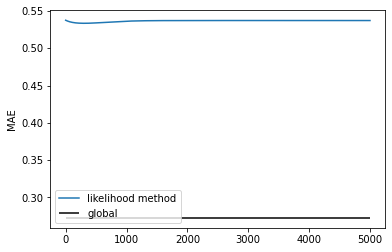

/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


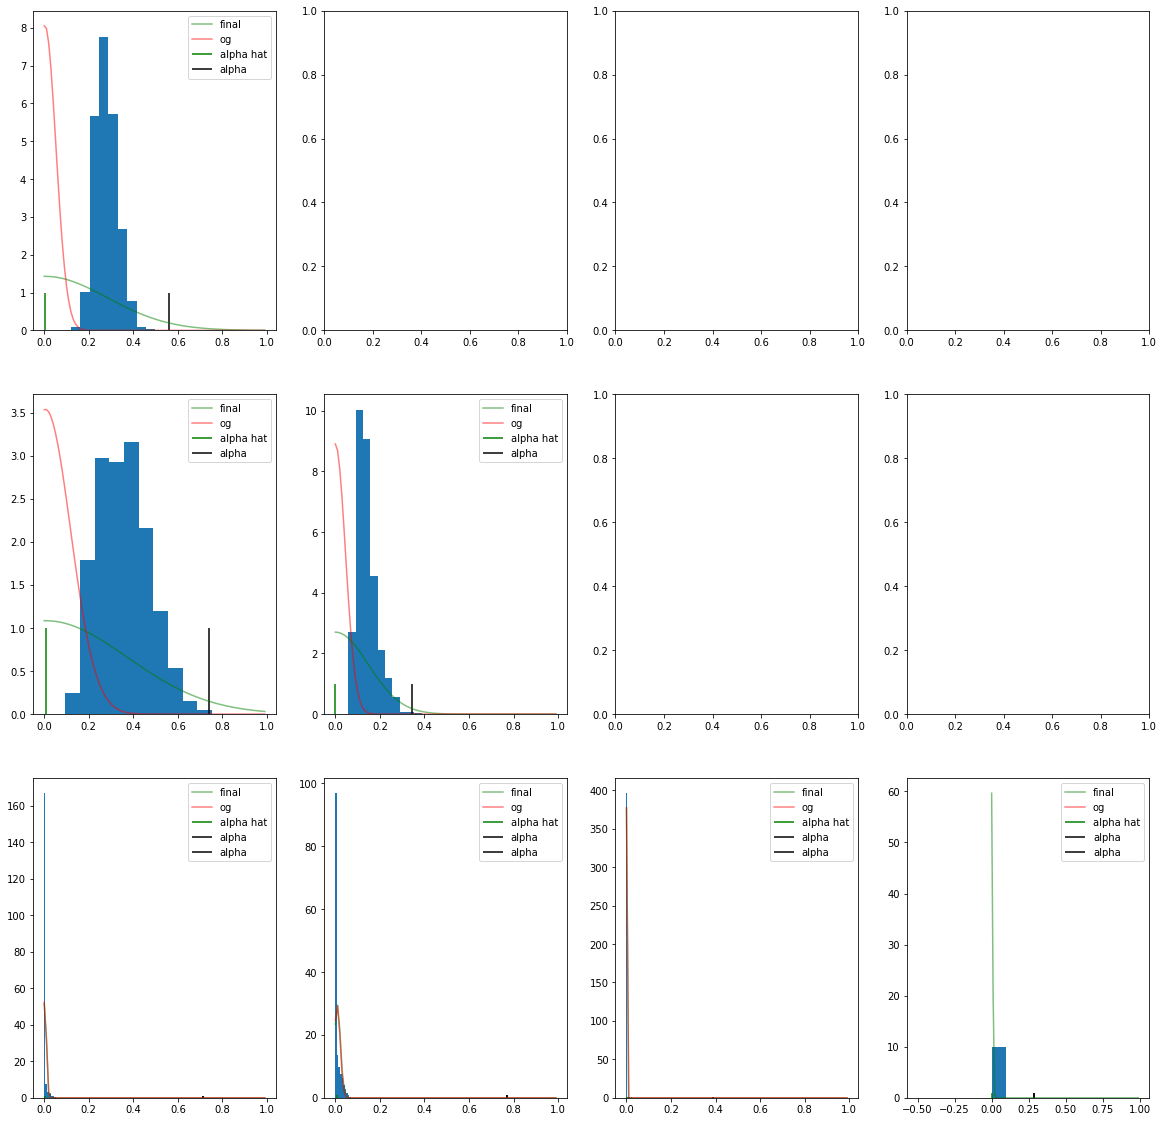

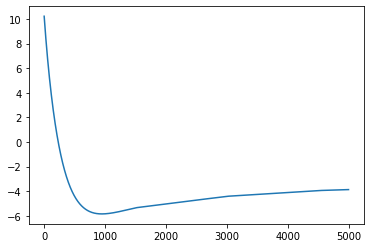

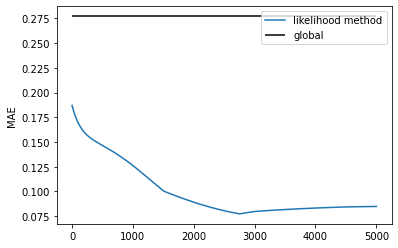

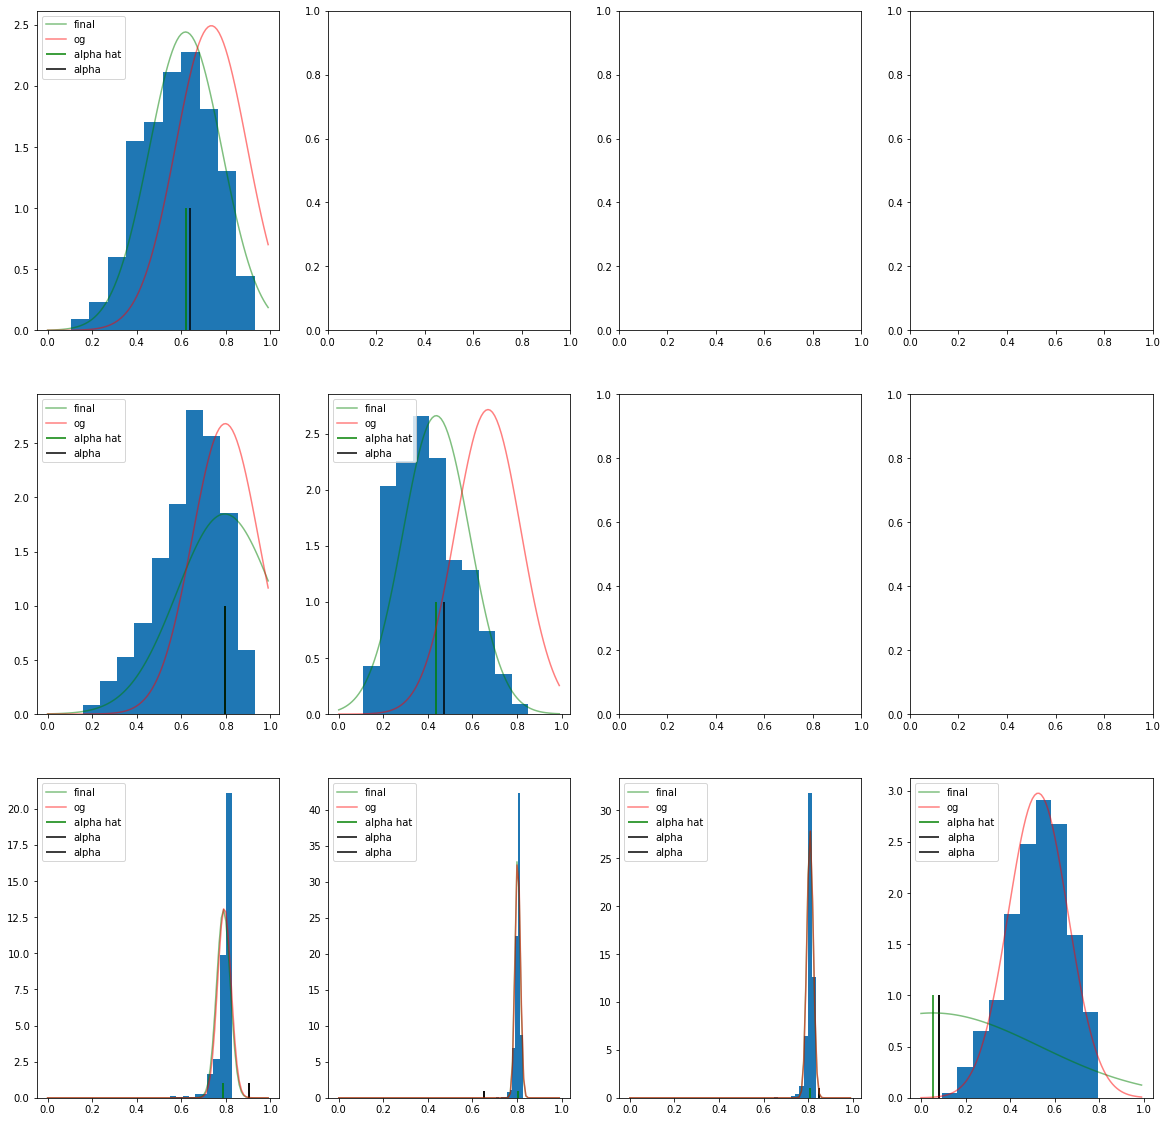

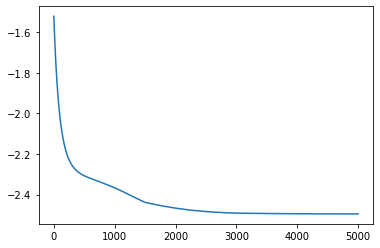

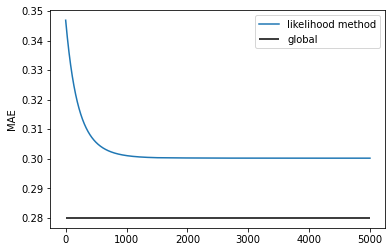

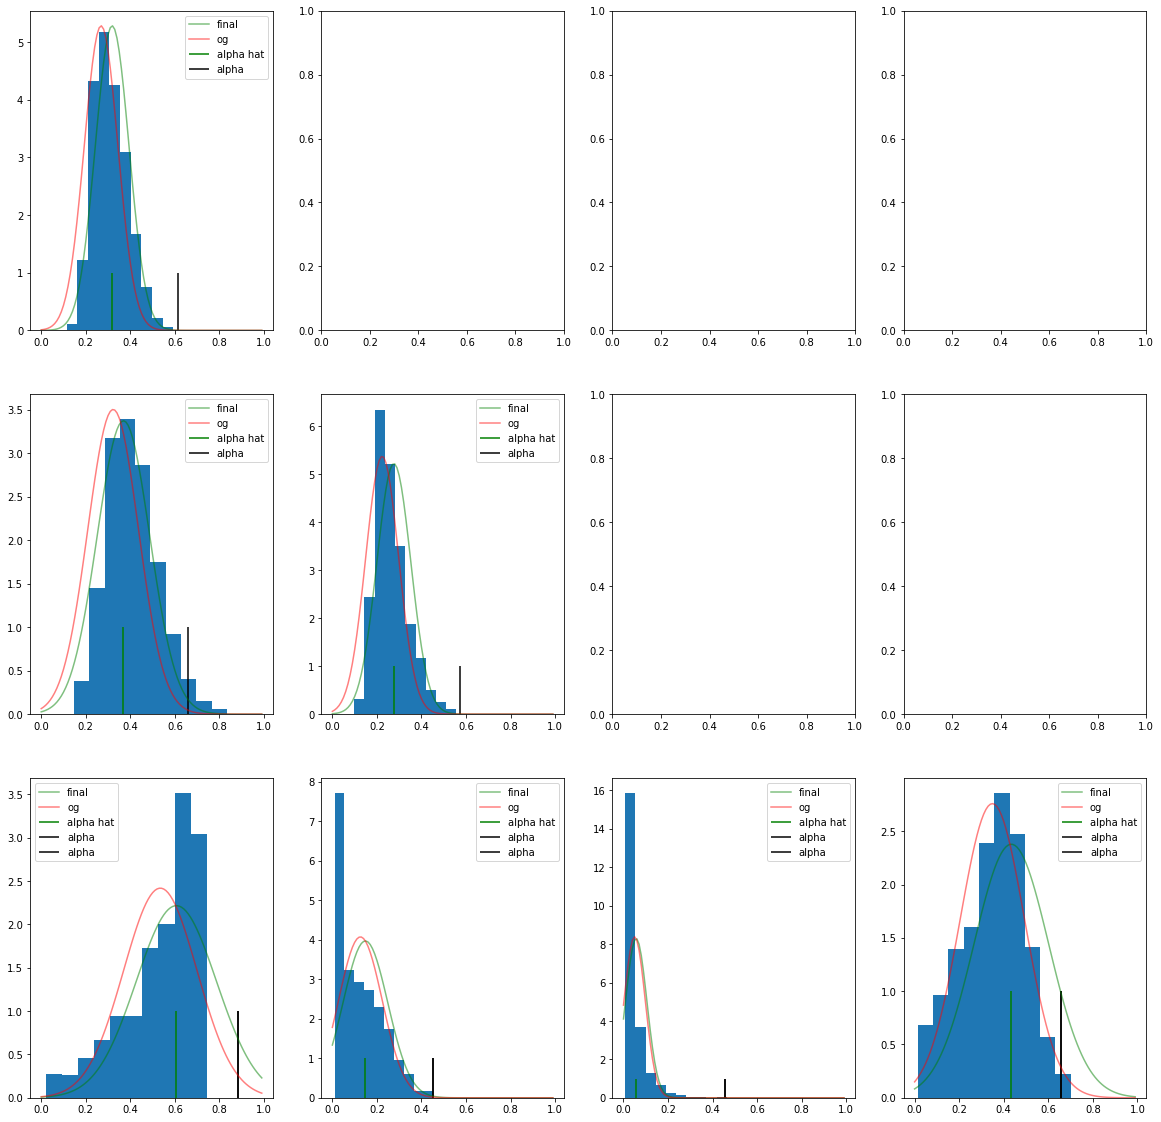

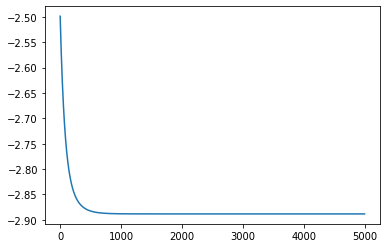

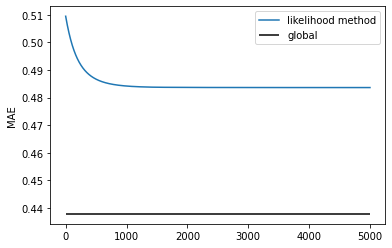

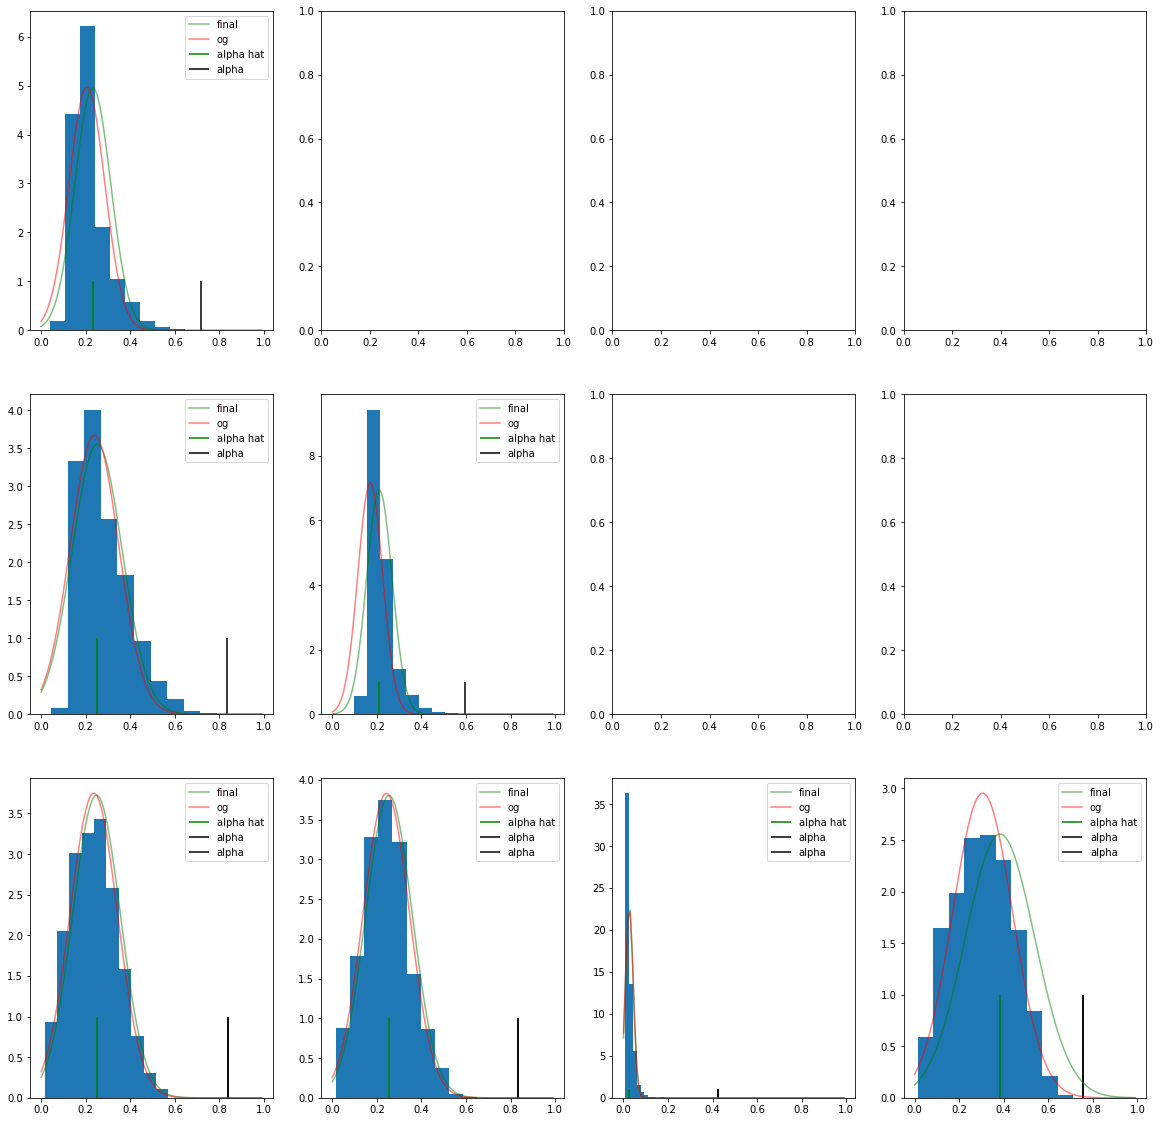

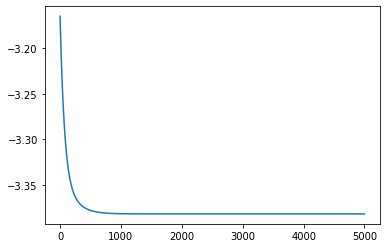

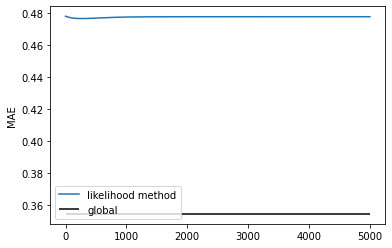

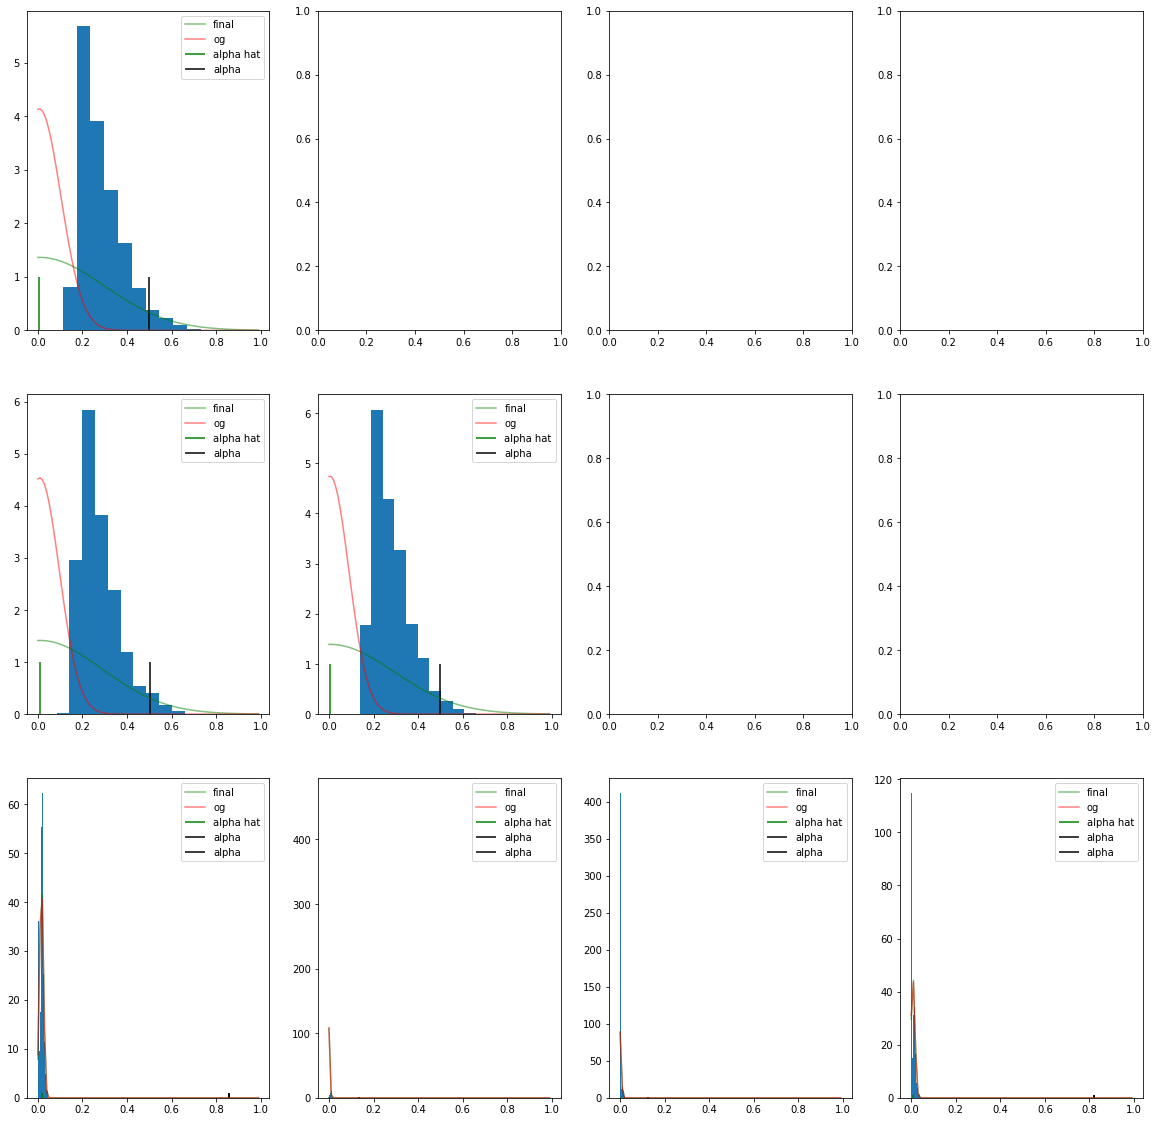

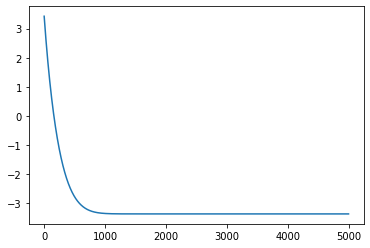

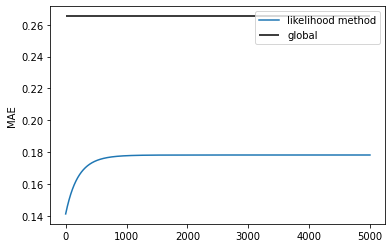

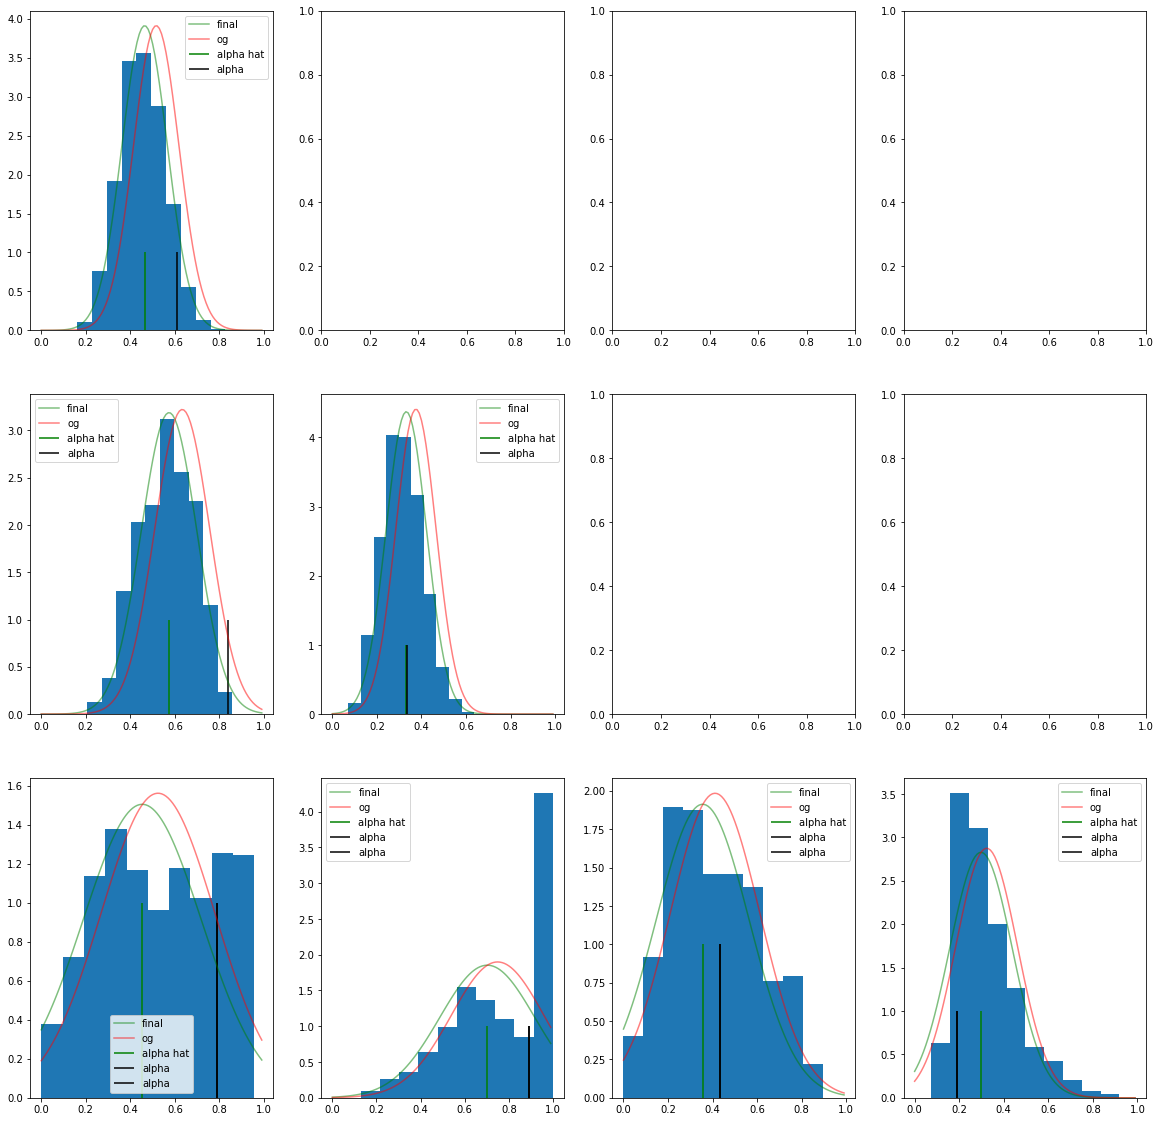

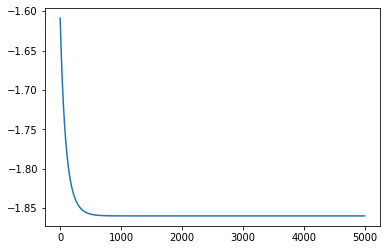

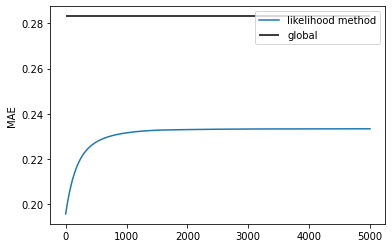

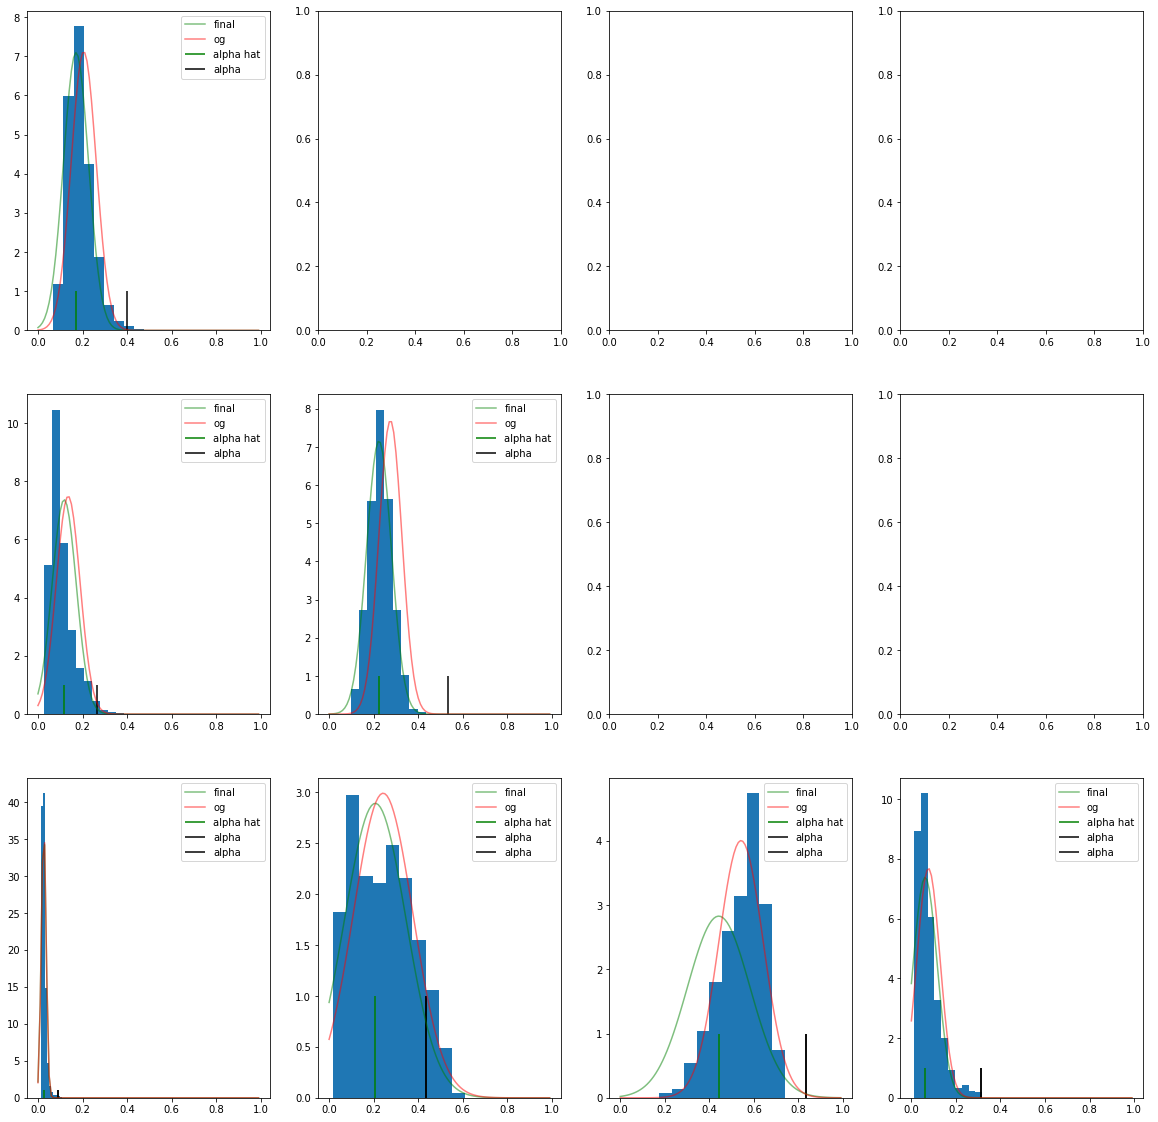

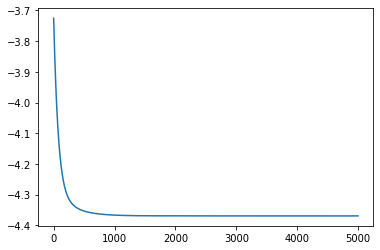

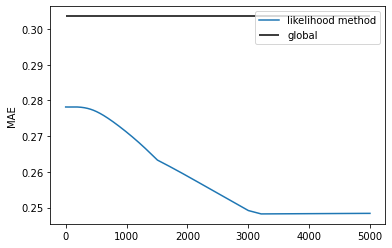

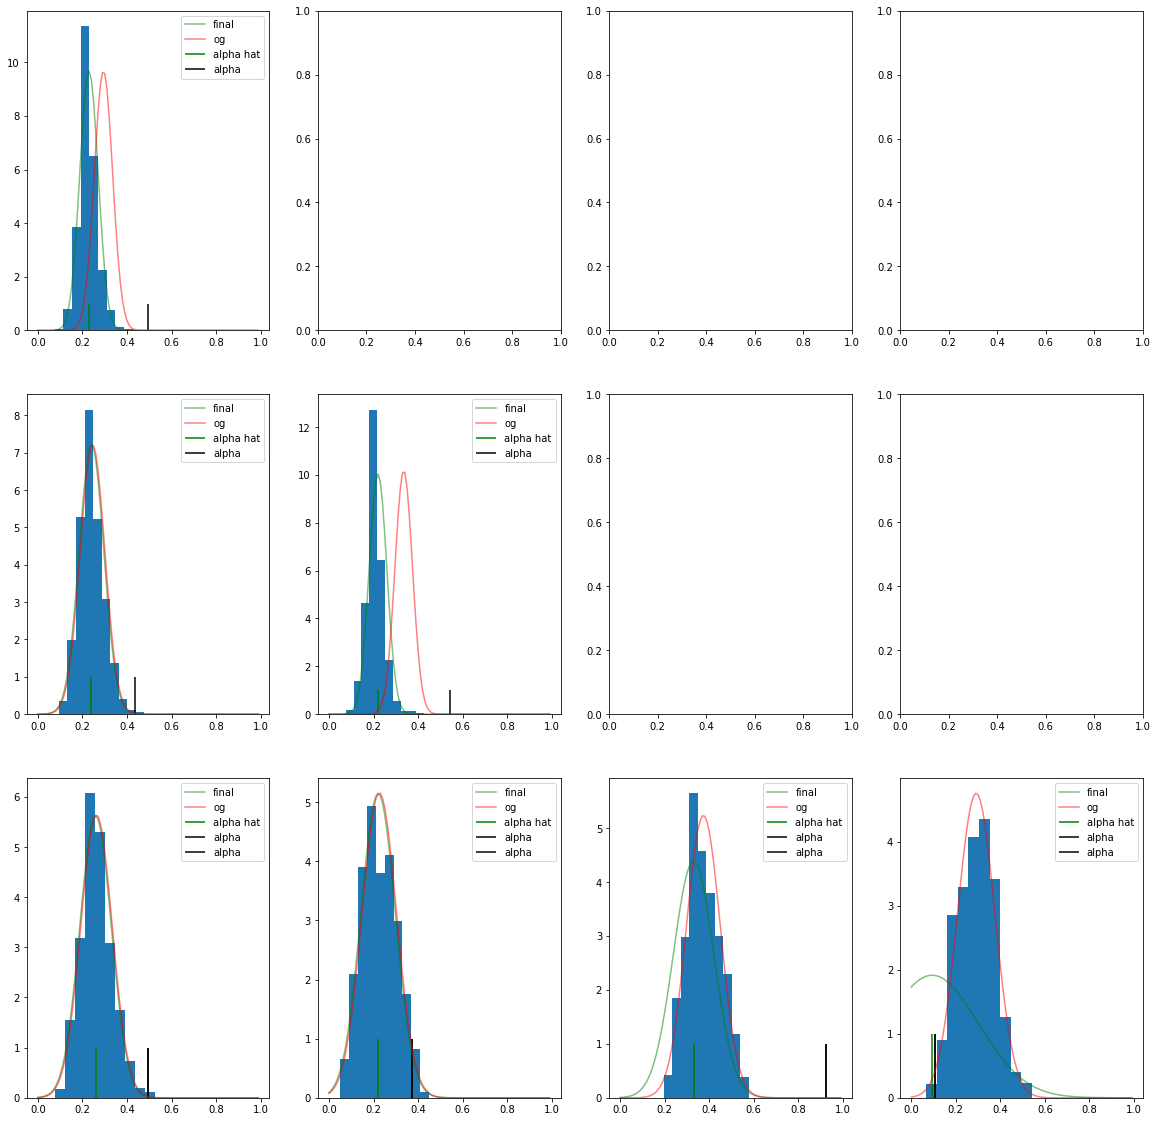

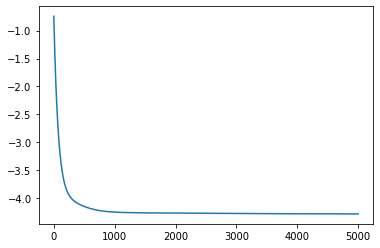

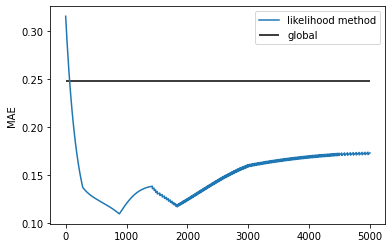

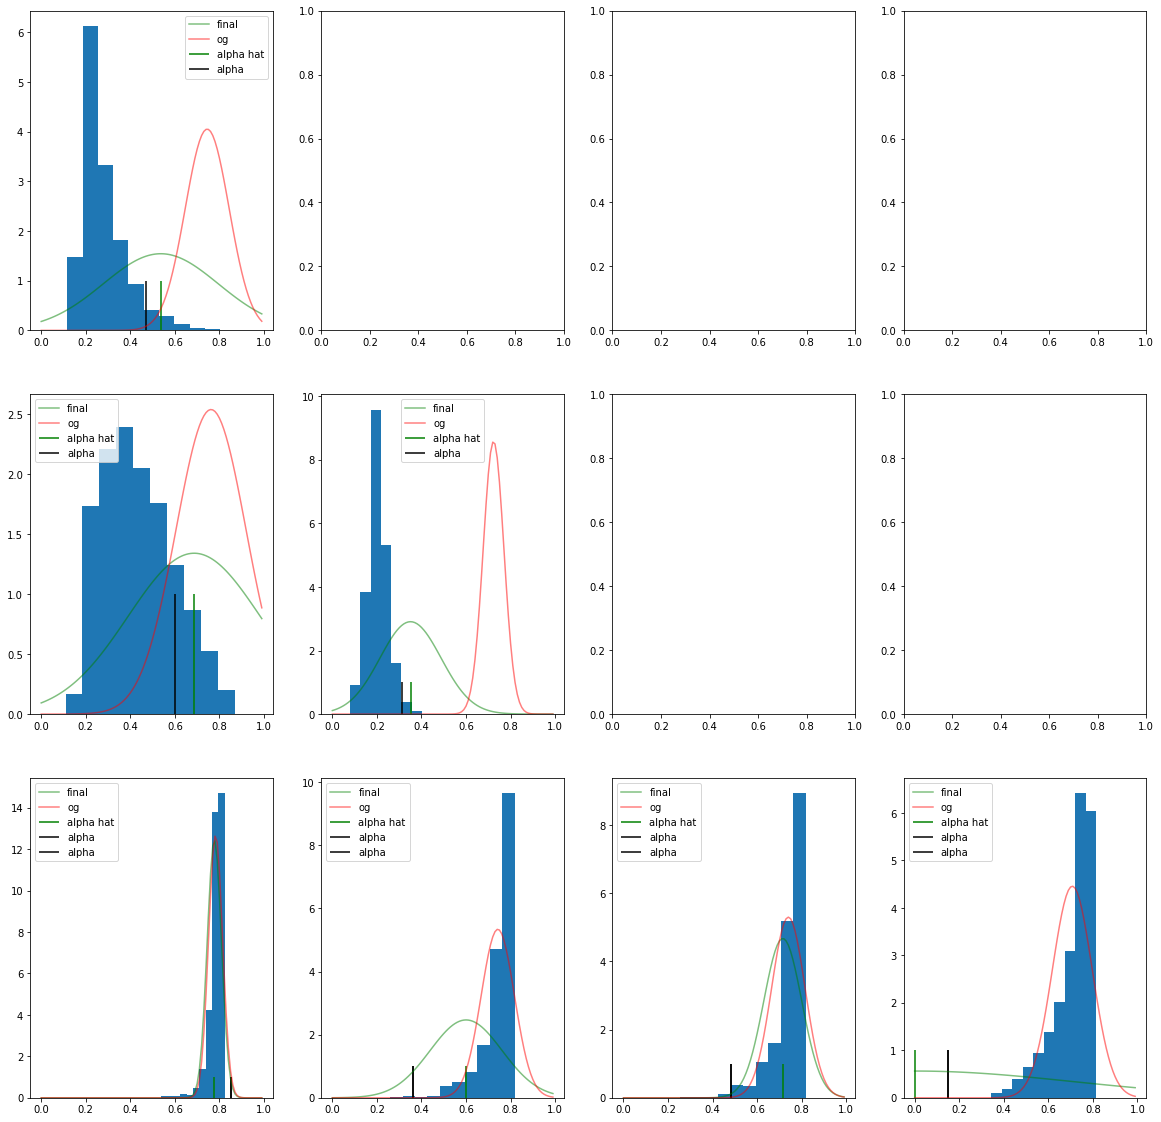

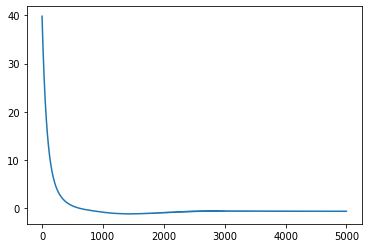

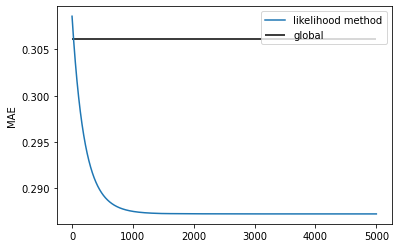

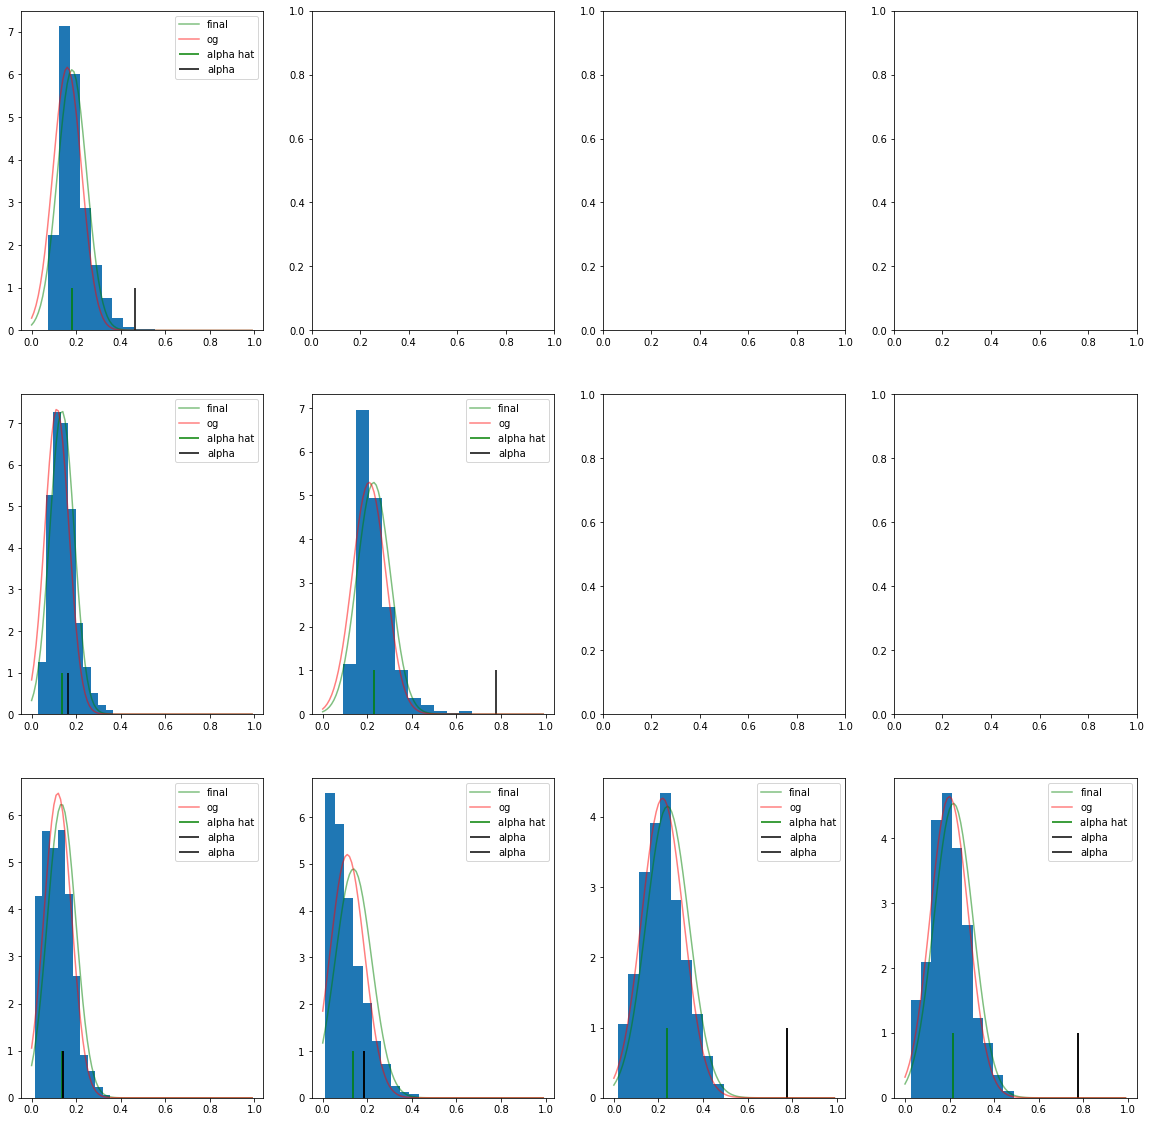

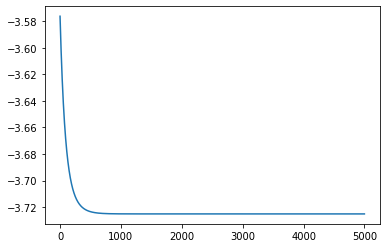

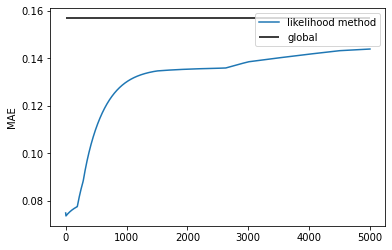

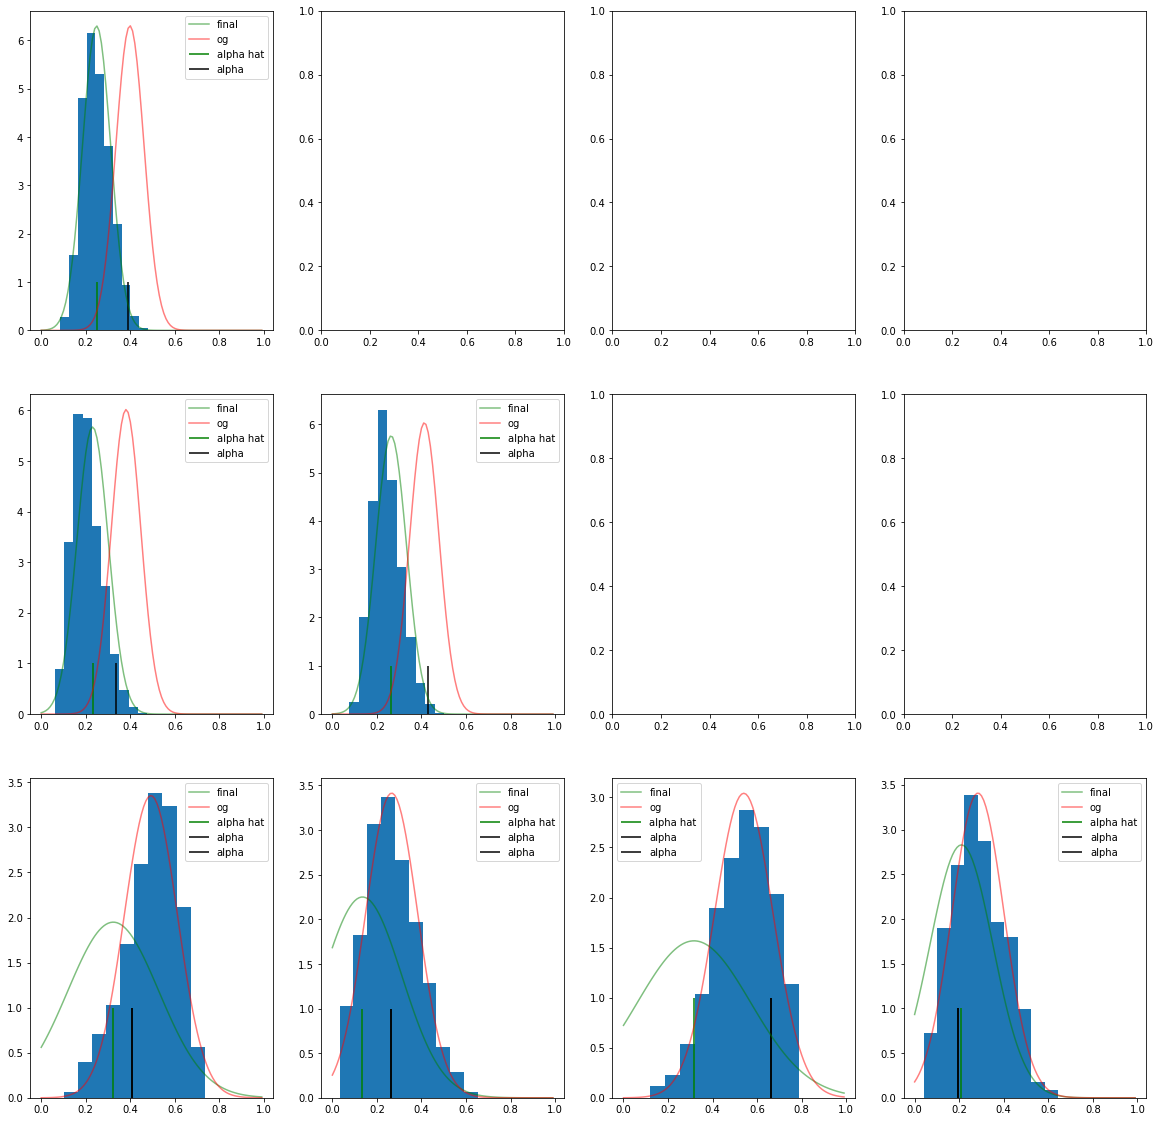

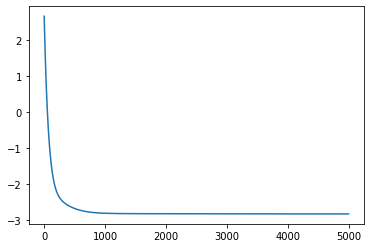

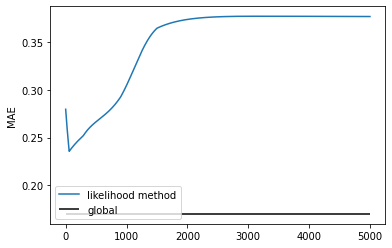

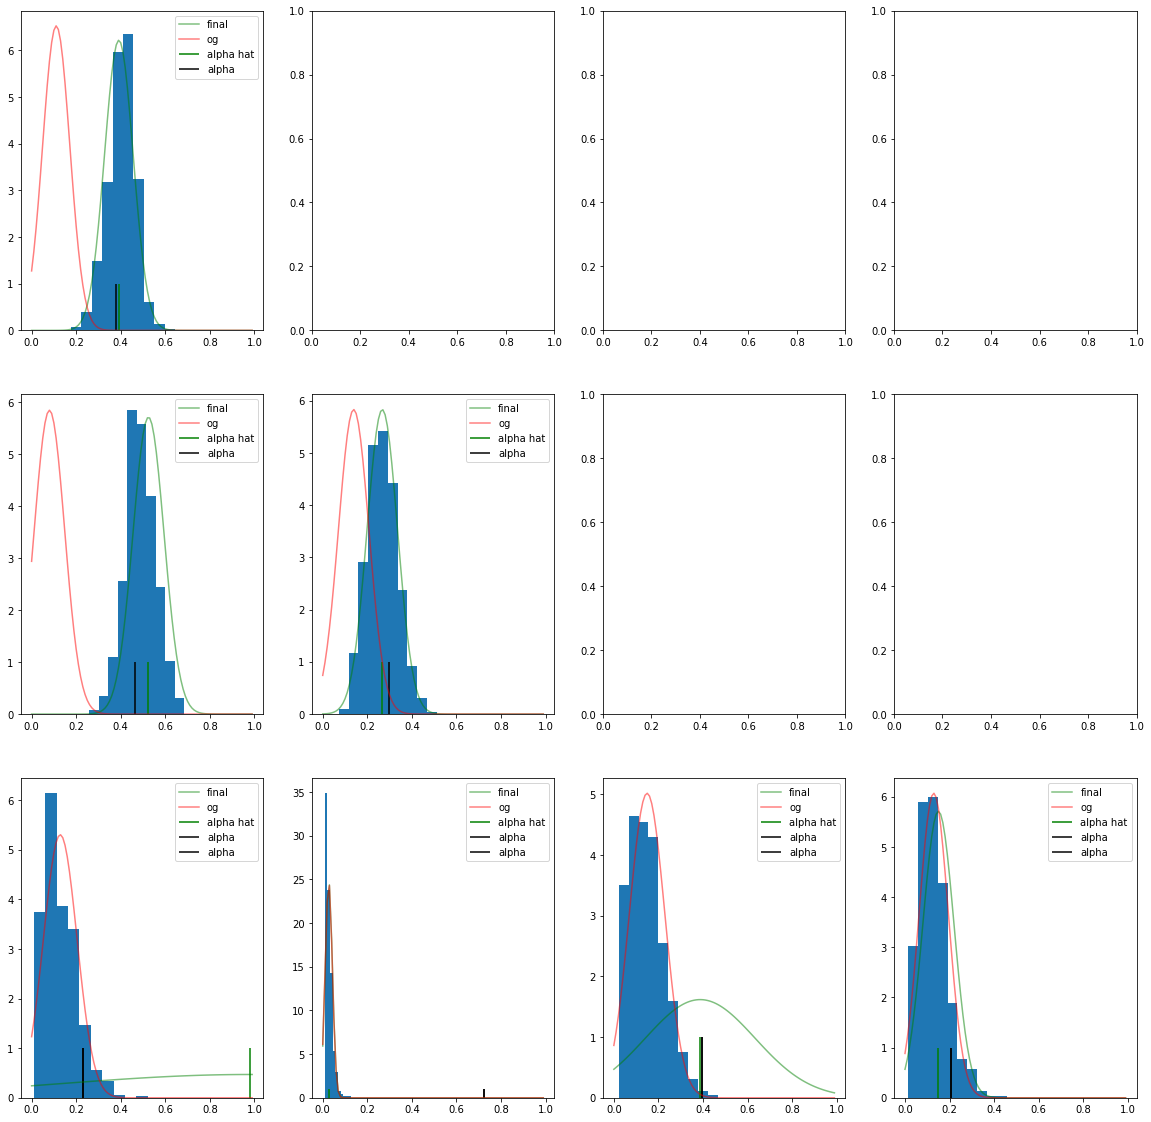

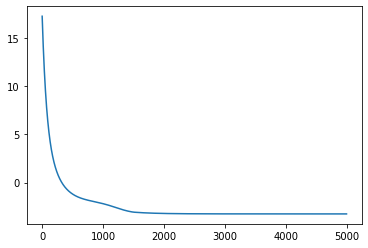

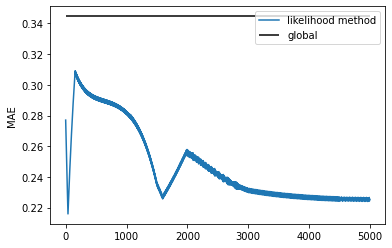

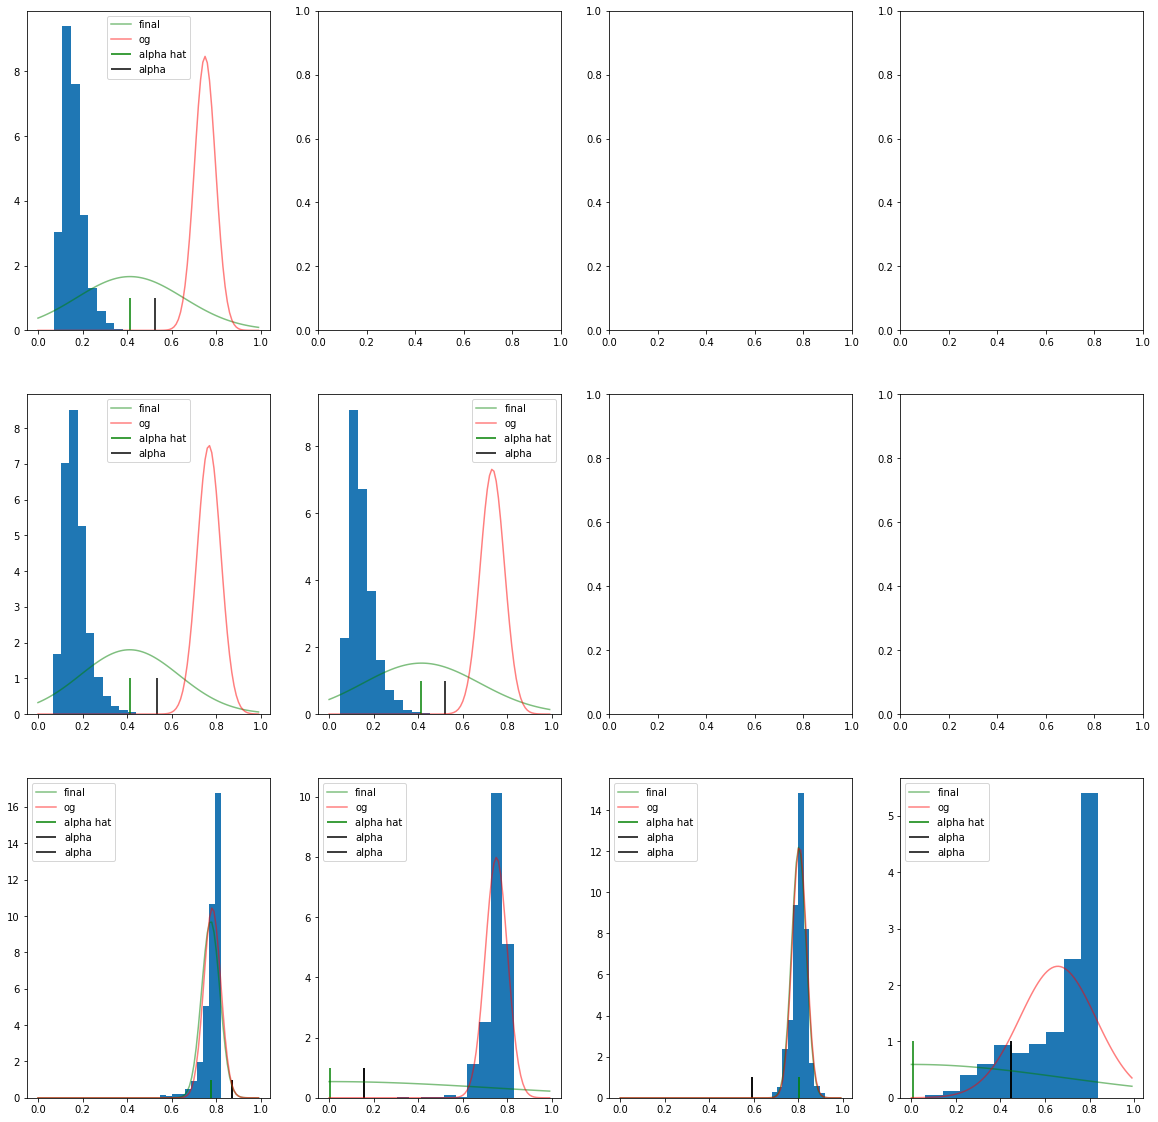

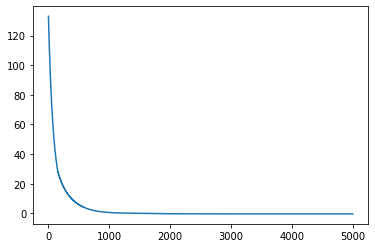

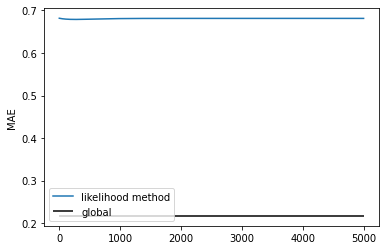

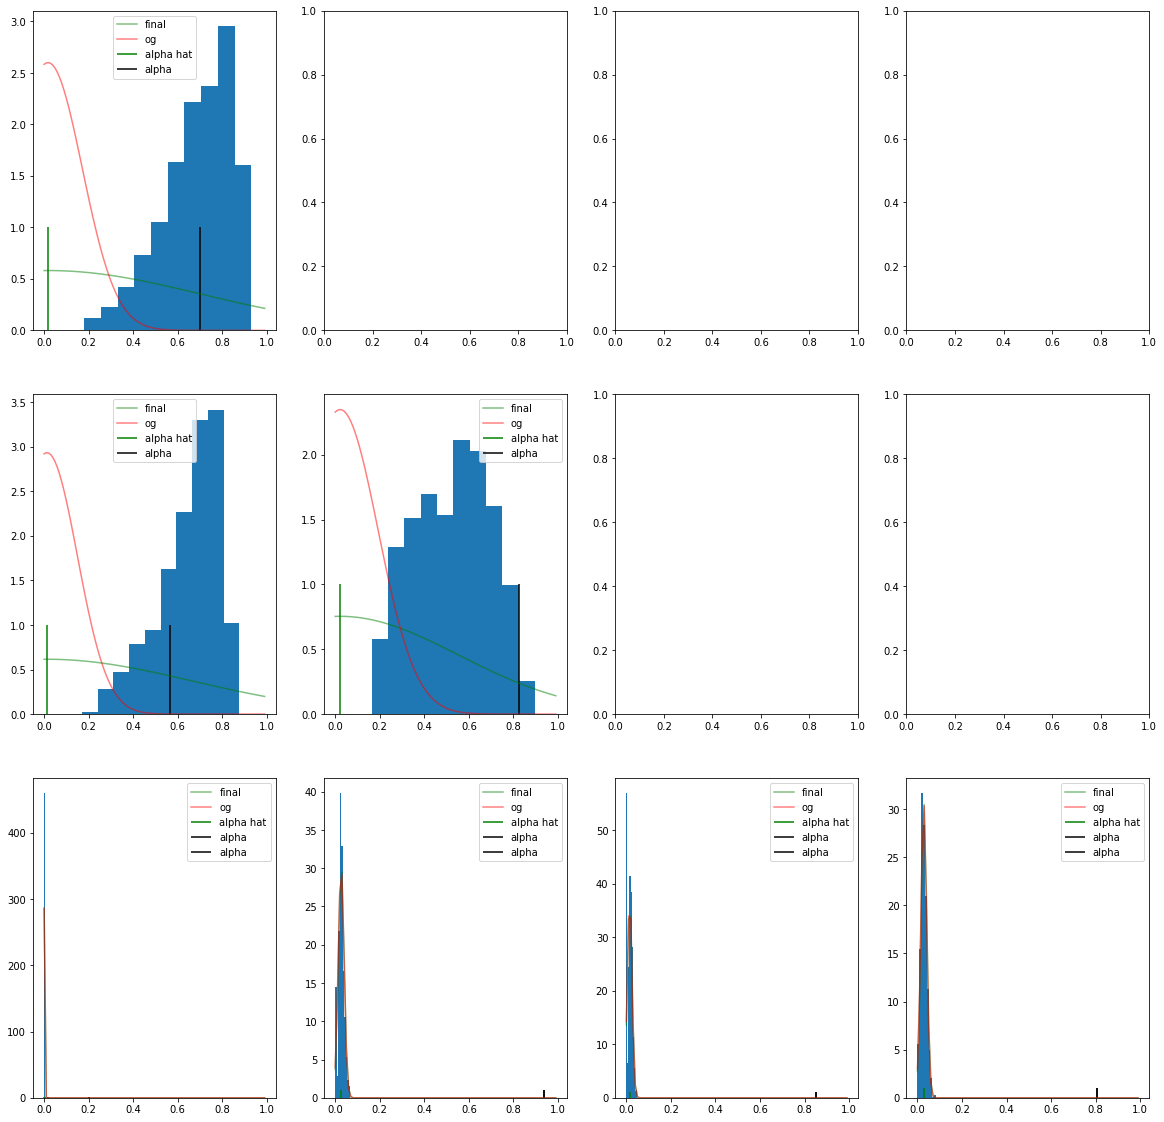

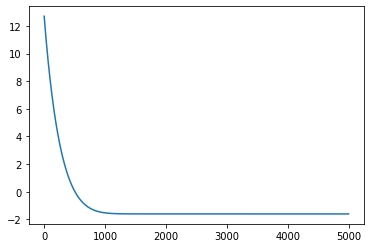

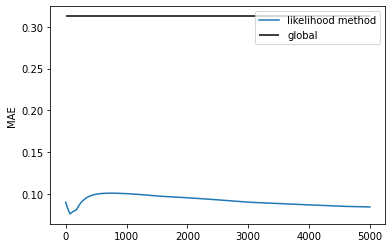

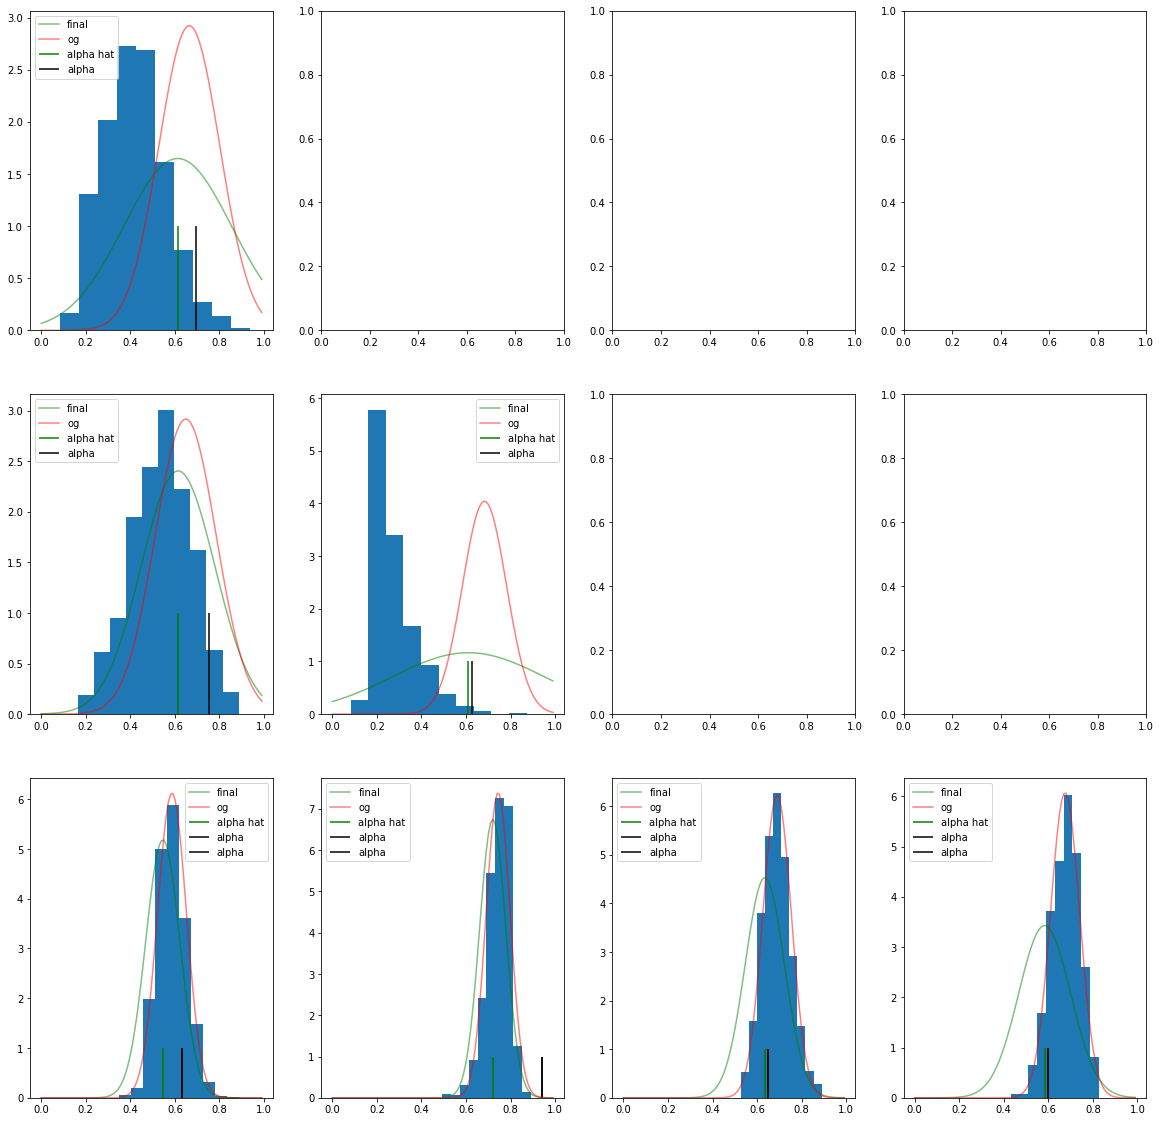

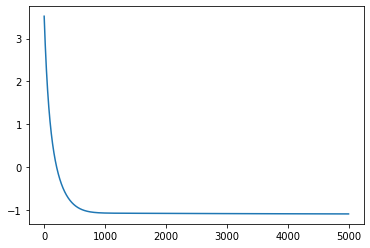

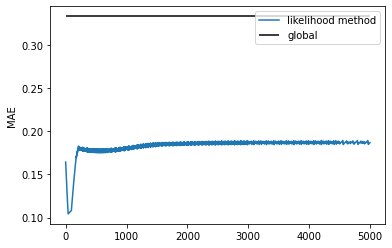

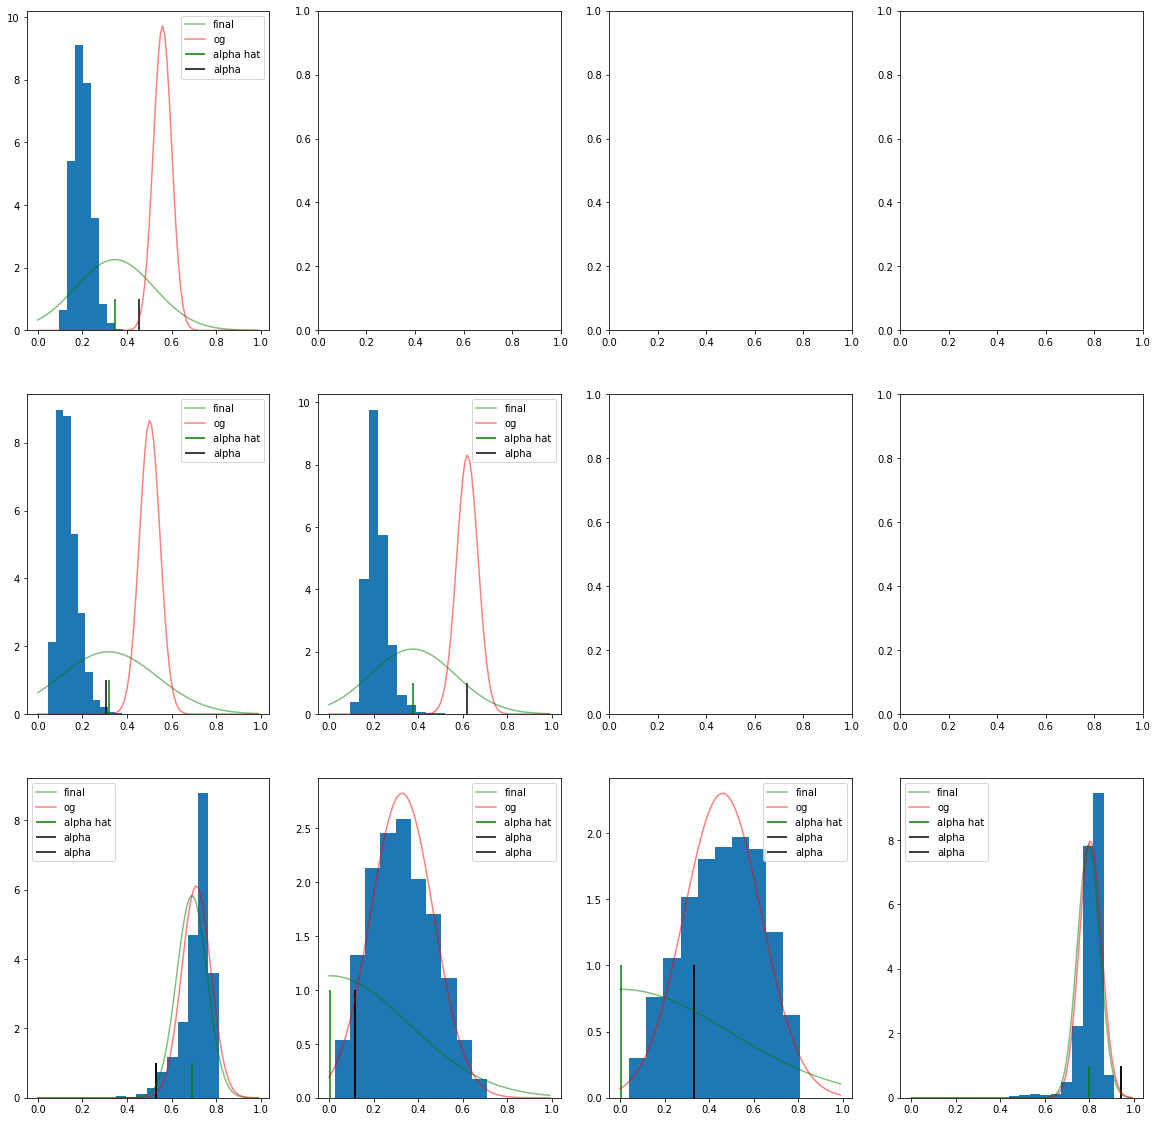

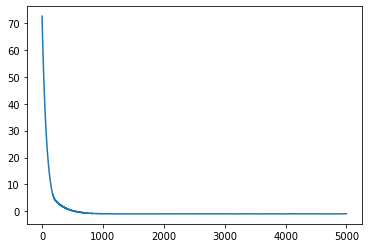

AssertionError: 

In [22]:
# fileNames = glob("/data/dzeiberg/ClassPriorEstimation/rawDatasets/*.mat")
fileNames = glob("/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/*.mat")
absErrs = {"local":0,
        "global":0,
        "likelihood":0}
N = 0
for fileName in tqdm(fileNames,total=len(fileNames)):
# for fileName in tqdm(fileNames[:10],total=10):
    dsn = fileName.split("/")[-1].replace(".mat","")
    dsi = buildReal(fileName,4,
                       alphaDistr=lambda: np.random.uniform(.05,.95),
                      nPDistr=lambda: 1 + np.random.poisson(25),
                      nUDistr=lambda: 1 + np.random.poisson(75))
    dsi = prepDS(dsi,numbootstraps=1000)
    dsi, mus,sigmas,maes,NLL = runAlgorithm(dsi,
                                            NIter=5000,
                                            rlambda=.5,)
    absErrs["local"] = absErrs["local"] + maes[0] * dsi.N
    absErrs["likelihood"] = absErrs["likelihood"] + maes[-1] * dsi.N
    absErrs["global"] = absErrs["global"] + np.abs(dsi.globalAlphaHats.mean() - dsi.trueAlphas.flatten()).sum()
    N += dsi.N
    maefig = plotMAE(maes,dsi)
    plt.show()
    dstrFig = plotDistrs(dsi,mus,sigmas)
    plt.show()
    fig,ax= plt.subplots()
    ax.plot(NLL)
    plt.show()
    maefig.savefig("figs/nb_19/real2/{}_mae.pdf".format(dsn),format="pdf")

    dstrFig.savefig("figs/nb_19/real2/{}_distrs.pdf".format(dsn),format="pdf")
    fig.savefig("figs/nb_19/real2/{}_nll.pdf".format(dsn),format="pdf")

In [25]:
with open("figs/nb_19/real2/res.txt","w") as f:
    f.write("row lambda: .5\n16 datasets\n")
    for k,v in absErrs.items():
        f.write("{}: {:.3f}\n".format(k, v/N))

In [27]:
cat figs/nb_19/real1/res.txt

No level gradient scaling
12 datasets
local: 0.338
global: 0.272
likelihood: 0.321


In [28]:
cat figs/nb_19/real2/res.txt

row lambda: .5
16 datasets
local: 0.304
global: 0.285
likelihood: 0.294
